## Localization Task

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl, models as tfkm
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet import preprocess_input
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import numpy as np
import random
from sklearn.utils import class_weight
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import load_model


In [44]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Goal: develop clue detection as a full auxiliary task

rk) can pair it with self-supervised or weakly supervised pretraining ??

We have the binary clue labels $\texttt{clues\_df}$ for ball, referee and gate.

In [3]:
clues_df = pd.read_csv('clues.csv', index_col=0)
clues_df.head()

,Gate,Ball,Referee
img_id,,,
1,0,0,0
2,0,0,1
94,0,1,1
95,0,1,1
96,0,1,1


## Weakly Supervised Object Localization (WSOL)

Can be useful to perform localization without training images annotated with bounding boxes.

We exploit the dataset's feature of being annotated for classification, with image pairs $\{X_i, \ell\}$,
- $X_i \in X$ set of images;
- $\ell \in \Lambda$ set of labels.

What we intend to do is:

- Training a classifier for multiplòe object categories (referee, gate, ball)
    - train with image-level labels

- the network ends with:
    - GAP (Global Averaging Pooling) layer on final conv feature map
    - FC layer to output logits

Then: CAM or Grad-CAMs can be computed directly from the weights of the FC layer and the conv feature map to infer the **bounding box location**.

Pro: class-specific saliency technique

## Step 1. GAP + FC + CAM

Each image may contain 0, 1, 2, or 3 clues. Since it could be useful to use an incremental ablation study, i separate the models into one binary classifier per clue. Also, a single image gives always the same activations, but the heatmaps (CAM outputs) may vary based on the weights, which depend on the class.

### Referee

Start training a binary classifier using the labels:
- 1: the referee is visible
- 0: the referee is not

RK) Class Activation Maps are class-specific.
- “where the network looks” to make a decision for a certain class.
- require:
    - Supervised learning
    - A specific class prediction (because the weights from FC layer point to the class-specific regions)



We extract the image ids and the labels:

In [65]:
image_ids = clues_df.index.astype(str).to_numpy()
ref_label = clues_df['Referee'].values

In [66]:
image_ids

array(['1', '2', '94', ..., '47062', '83692', '87448'], dtype=object)

In [67]:
print(f"Nr images: {len(image_ids)}")
print(f"Label Referee Distribution:\n 0\t\t1")
print("----------------------")
print(f"{sum(ref_label.tolist()) / len(image_ids)}\t\t{1- (sum(ref_label.tolist()) / len(image_ids))}")

Nr images: 10000
Label Referee Distribution:
 0		1
----------------------
0.3254		0.6746


not severe imbalance, but still meaningful. The model may become biased toward class 1 ("referee present"), simply because it sees it more often. Given that the goal is localization, and I want to extract CAMs only when the model predicts 1, it is better to **avoid false positives**. (better not to have a bounding box than having a wrong one).

Since one class is appearing approx twice as much as the other, can compute it exactly.

In [68]:
#class_weight = {
#    0: 1.0,  
#    1: 0.5  
#}

### MobileNetV2
(try for prototyping, faster), lightweight pretrained on ImageNet

**rk** ResNet 18 (better performance, check if CAM is visible, slower training)

**rk** eventually cnn

In [69]:
# train-test split
train_ids, val_ids, y_train, y_val = train_test_split(
    image_ids, ref_label,
    test_size=0.2,
    stratify=ref_label,
    random_state=SEED
)

#### Loading and Preprocessing

We defining the image loader: (256x256), 

**ASK** --> what about the size?? squared??

In [70]:
target_dim = (256, 256)

def load_images_from_path(image_ids, path="Filtered_Dataset", img_dim=(224, 224)):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(path, f"{img_id}.jpg")
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_dim)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images, dtype='float32')

In [71]:
# load raw:
X_train = load_images_from_path(train_ids, img_dim=target_dim)
X_val  = load_images_from_path(val_ids, img_dim=target_dim)

In [72]:
# preprocessing for MobileNetV2
# Rescales input from [-1, 1]
X_train_pre = preprocess_input(X_train)
X_val_pre = preprocess_input(X_val)

Rebalancing classes:

In [73]:
from sklearn.utils import class_weight

weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: weights_array[0], 1: weights_array[1]}

Model: use defaulting weights of imagenet.

'pooling' = None as default: means that the output of the model will be the 4D tensor output of the last convolutional block.

trainable=False--> Freezes the base model so its weights are **not updated** during training

In [74]:
target_dim[0]

256

In [75]:
input_shape = (target_dim[0], target_dim[1], 3)


def mobnetv2_ref(input_shape=input_shape):
    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False

    inputs = tfkl.Input(shape=input_shape)
    x = base(inputs)

    # apply GAP --> reduces feature map from (7,7,1280) to (1280,)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # FC dense layer, single output unit
    # binary classification --> pr(referee in the image)
    output = tfkl.Dense(1, activation='sigmoid', name='MobileNetV2_Ref')(x)

    model = tfkm.Model(inputs=inputs, outputs=output)
    return model

In [76]:
ref_model1 = mobnetv2_ref()

ref_model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision')]
)

history = ref_model1.fit(
                    X_train_pre, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_pre, y_val),
                    class_weight=class_weights,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                    ],
                    verbose=1
                )


C:\Users\Utente\AppData\Local\Temp\ipykernel_29748\1842098600.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.7098 - loss: 0.5700 - precision: 0.5492 - val_accuracy: 0.7975 - val_loss: 0.4663 - val_precision: 0.6507
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 832ms/step - accuracy: 0.7910 - loss: 0.4613 - precision: 0.6439 - val_accuracy: 0.8150 - val_loss: 0.4399 - val_precision: 0.6754
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 196s 777ms/step - accuracy: 0.8072 - loss: 0.4307 - precision: 0.6644 - val_accuracy: 0.8215 - val_loss: 0.4256 - val_precision: 0.6865
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 176s 702ms/step - accuracy: 0.8149 - loss: 0.4123 - precision: 0.6741 - val_accuracy: 0.8245 - val_loss: 0.4164 - val_precision: 0.6904
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 680ms/step - accuracy: 0.8182 - loss: 0.3992 - precision: 0.6791 - val_accuracy: 0.8280 - val_loss: 0.4100 - val_precision: 0.6955
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 682ms/step - accuracy: 0.8231 - loss: 0.3891 - precision: 0.6859 - val_accurac

In [77]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Accuracy and Precision over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


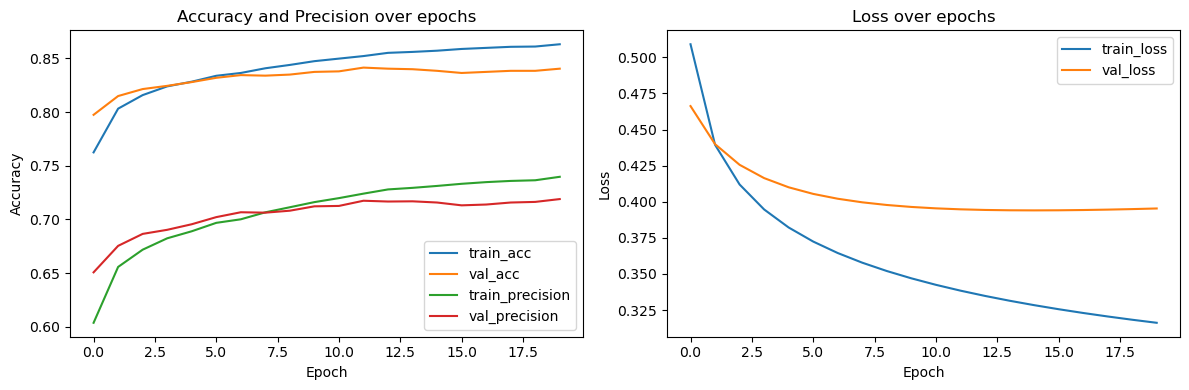

In [78]:
plot_training_history(history)

tune sensitivity: can apply a decision threshold to reduce false positives

In [79]:
y_probs = ref_model1.predict(X_val_pre, batch_size=32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 551ms/step


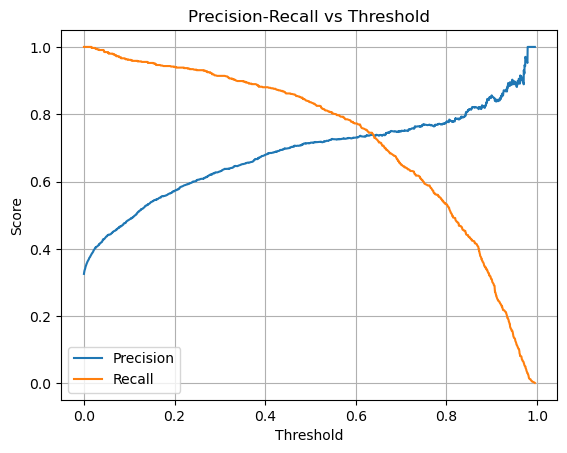

In [80]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Save model

In [81]:
ref_model1.save("Referee_CAM_Model.h5")

In [107]:
ref_model1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV2_Ref (Dense)         │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

#### Generate Cam

CAM = $\sum_k w_k f_k(x)$,
- $w_k$: weights from dense layer
- $f_k(x)$: activation maps from final conv layer

In [122]:
def generate_cam(model, image, class_index=0):
    """
    Generate a CAM for a preprocessed image using MobileNetV2 backbone.
    Args:
        model: the trained full model (with MobileNetV2 base)
        image: a preprocessed RGB image, shape (H, W, 3)
    Returns:
        CAM heatmap (H, W) normalized to [0, 1]
    """
    # Get MobileNetV2 submodel
    base_model = model.get_layer("mobilenetv2_1.00_224")
    
    # Get input and output tensors for Conv_1
    conv_layer = base_model.get_layer("Conv_1")
    
    # Build submodel: Input → Conv_1 output
    conv_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=conv_layer.output
    )

    # Expand dims to make batch of 1 if needed
    if image.ndim == 3:
        image_batch = np.expand_dims(image, axis=0)
    else:
        image_batch = image

    # Run forward pass to get conv output
    conv_output = conv_model(image_batch)[0].numpy()  # shape: (Hc, Wc, C)

    # Get weights from final dense layer
    weights = model.get_layer("MobileNetV2_Ref").get_weights()[0][:, class_index]

    # Compute weighted sum of conv feature maps
    cam = np.dot(conv_output, weights)

    # Normalize and resize to original image size
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))

    return cam

In [121]:
#def overlay_cam_on_image(image, cam, alpha=0.5, cmap='jet'):
#    """
#    Overlays the CAM on the image for visualization.
#    image: RGB image (H, W, 3)
#    cam: heatmap (H, W) with values in [0, 1]
#    """
#    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
#    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
#
#    overlay = (alpha * heatmap + (1 - alpha) * image).astype(np.uint8)
#
#    plt.imshow(overlay)
#    plt.axis("off")
#    plt.title("CAM Overlay")
#    plt.show()

def overlay_cam_on_image(image, cam, alpha=0.5, cmap='jet'):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("CAM Overlay")
    plt.show()

Test it

In [201]:
from PIL import Image

In [212]:
clues_df[clues_df['Referee']==1].head()
a = Image.open("Filtered_Dataset\95.jpg")
b = 95

In [185]:
train_ids[y_train == 1][0]
#train_ids


'56984'

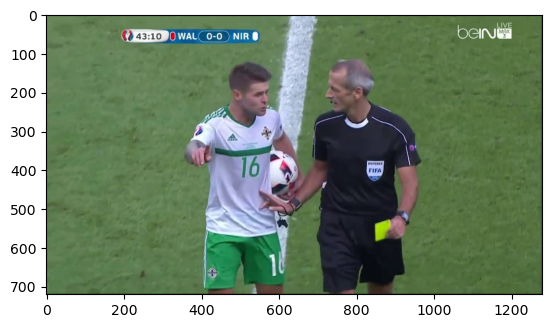

In [204]:
plt.imshow(a)

In [211]:
a.width

1280

In [214]:
test_cam_id = train_ids[y_train == 1][0]  # get one positive example
img_raw = load_images_from_path([b], img_dim=target_dim)[0]
img_pre = preprocess_input(img_raw.astype(np.float32))  # shape: (H, W, 3)

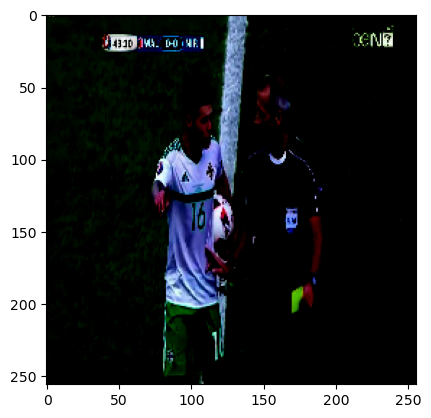

In [215]:
plt.imshow(img_pre)

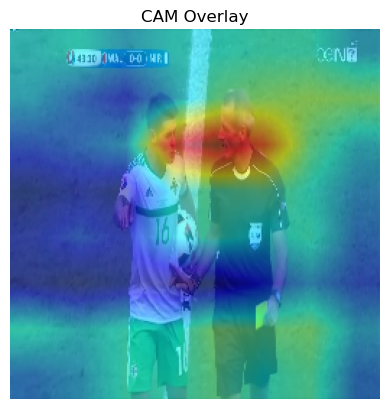

In [216]:
# Generate CAM
cam = generate_cam(ref_model1, img_pre)
#cam_smooth = cv2.GaussianBlur(cam, (7, 7), sigmaX=2)

# Overlay on original image
overlay_cam_on_image(img_raw.astype(np.uint8), cam)

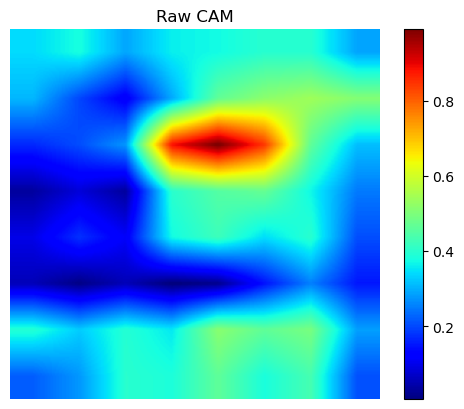

In [217]:
plt.imshow(cam, cmap='jet')
plt.colorbar()
plt.title("Raw CAM")
plt.axis("off")
plt.show()

### Step 2. From CAM into bounding boxes and masks

#### Bounding Box

We want to threshold the CAM, so convert it into a binary mask:
- 1: region that the model strongly associates with the referee
- 0: irrelevant background

In [218]:
def threshold_cam(cam, threshold=0.6):
    """
    Threshold CAM to create a binary mask.
    """
    binary_mask = np.uint8(cam >= threshold) * 255  # binary image (0 or 255)
    return binary_mask

#def get_bounding_box_from_mask(mask):
#    """
#    Extract the bounding box (x1, y1, x2, y2) from the binary mask.
#    Returns None if no region is found.
#    """
#    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#    if not contours:
#        return None
#    largest_contour = max(contours, key=cv2.contourArea)
#    x, y, w, h = cv2.boundingRect(largest_contour)
#    return (x, y, x + w, y + h)

def get_bounding_box_from_mask(mask, min_area=500):
    """
    Extract the largest bounding box from the binary mask.
    Ignores small contours under min_area.
    Returns (x1, y1, x2, y2) or None if nothing found.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out tiny contours
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    if not large_contours:
        return None

    largest = max(large_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, x + w, y + h)



def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=1):
    """
    Draws a bounding box on the image.
    """
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        image = image.copy()
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image


Visualize Binary Mask:

In [219]:
mask = threshold_cam(cam, threshold=0.6)

Bounding Box:

In [220]:
bbox = get_bounding_box_from_mask(mask)

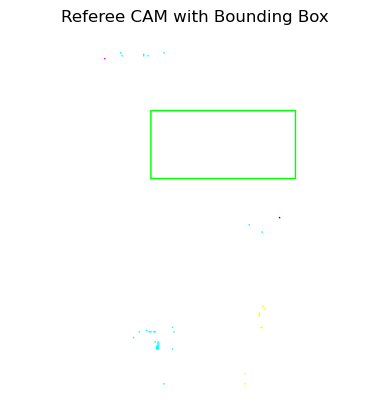

In [221]:
boxed_image = draw_bounding_box(img_raw, bbox)

plt.imshow(boxed_image)
plt.axis("off")
plt.title("Referee CAM with Bounding Box")
plt.show()

#### Optional: Train a lightweight CNN to directly regress bounding box using these pseudo-labels

**Backup Q**
- Why not supervised?

    Do not have bounding boxes  
- Why not unsupervised?

    we can rely on binary labels to guide training
- Why not self-supervised?

    Not relying on auxiliary tasks from raw data (e.g., rotation, colorization)

- Why not using pretrained sth?

However, self-supervised's activations focus more on object structure and entire object, and attentions maps tend to be more spatially distributed.

Cams focus more on discriminative object parts, and are more class-part selective.